## Bike demand predict

In [70]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

train = pd.read_csv("../input/bike-sharing-demand/train.csv")
test = pd.read_csv("../input/bike-sharing-demand/test.csv")
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [71]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
datetime      10886 non-null object
season        10886 non-null int64
holiday       10886 non-null int64
workingday    10886 non-null int64
weather       10886 non-null int64
temp          10886 non-null float64
atemp         10886 non-null float64
humidity      10886 non-null int64
windspeed     10886 non-null float64
casual        10886 non-null int64
registered    10886 non-null int64
count         10886 non-null int64
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [72]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 9 columns):
datetime      6493 non-null object
season        6493 non-null int64
holiday       6493 non-null int64
workingday    6493 non-null int64
weather       6493 non-null int64
temp          6493 non-null float64
atemp         6493 non-null float64
humidity      6493 non-null int64
windspeed     6493 non-null float64
dtypes: float64(3), int64(5), object(1)
memory usage: 456.7+ KB


In [73]:
train.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


In [74]:
test.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
count,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000
mean,2.493300,0.029108,0.685815,1.436778,20.620607,24.012865,64.125212,12.631157
std,1.091258,0.168123,0.464226,0.648390,8.059583,8.782741,19.293391,8.250151
min,1.000000,0.000000,0.000000,1.000000,0.820000,0.000000,16.000000,0.000000
25%,2.000000,0.000000,0.000000,1.000000,13.940000,16.665000,49.000000,7.001500
50%,3.000000,0.000000,1.000000,1.000000,21.320000,25.000000,65.000000,11.001400
75%,3.000000,0.000000,1.000000,2.000000,27.060000,31.060000,81.000000,16.997900
max,4.000000,1.000000,1.000000,4.000000,40.180000,50.000000,100.000000,55.998600


Range of variable in train and test is similar. So for now, i don't remove outlier

<br><br>

### Create variables and visualization
create columns from datetime

In [75]:
for df in [train, test]:
    df["datetime"] =  pd.DatetimeIndex(df["datetime"])
    df["hour"] = [x.hour for x in df["datetime"]]
    df["weekday"] = [x.dayofweek for x in df["datetime"]]
    df["month"] = [x.month for x in df["datetime"]]
    df["year"] = [x.year for x in df["datetime"]]
    df['year_season'] = df['year'].astype(str) + "_" +  df['season'].astype(str) 
    df["year"] = df["year"].map({2011:1, 2012:0})
    df.drop('datetime',axis=1,inplace=True)

See variables's distribution by distplot and countplot

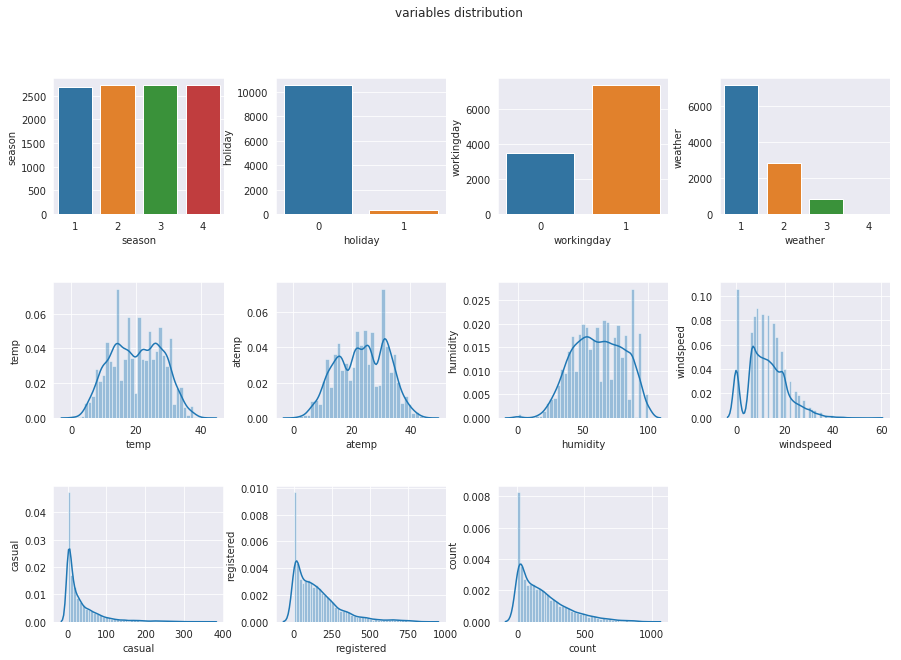

In [76]:
sns.set_style("darkgrid")
plt.figure(figsize=(15,10))
plt.suptitle('variables distribution')
plt.subplots_adjust(hspace = 0.5, wspace = 0.3)
for i, col in enumerate(train.columns[:11]):
    plt.subplot(3,4,i+1)
    if str(train[col].dtypes)[:3]=='int':
        if len(train[col].unique()) > 5:
            sns.distplot(train[col])
        else:
            sns.countplot(train[col])
    else:
        sns.distplot(train[col])
    plt.ylabel(col)

see relation of categorical predictors and outcomes by countplot

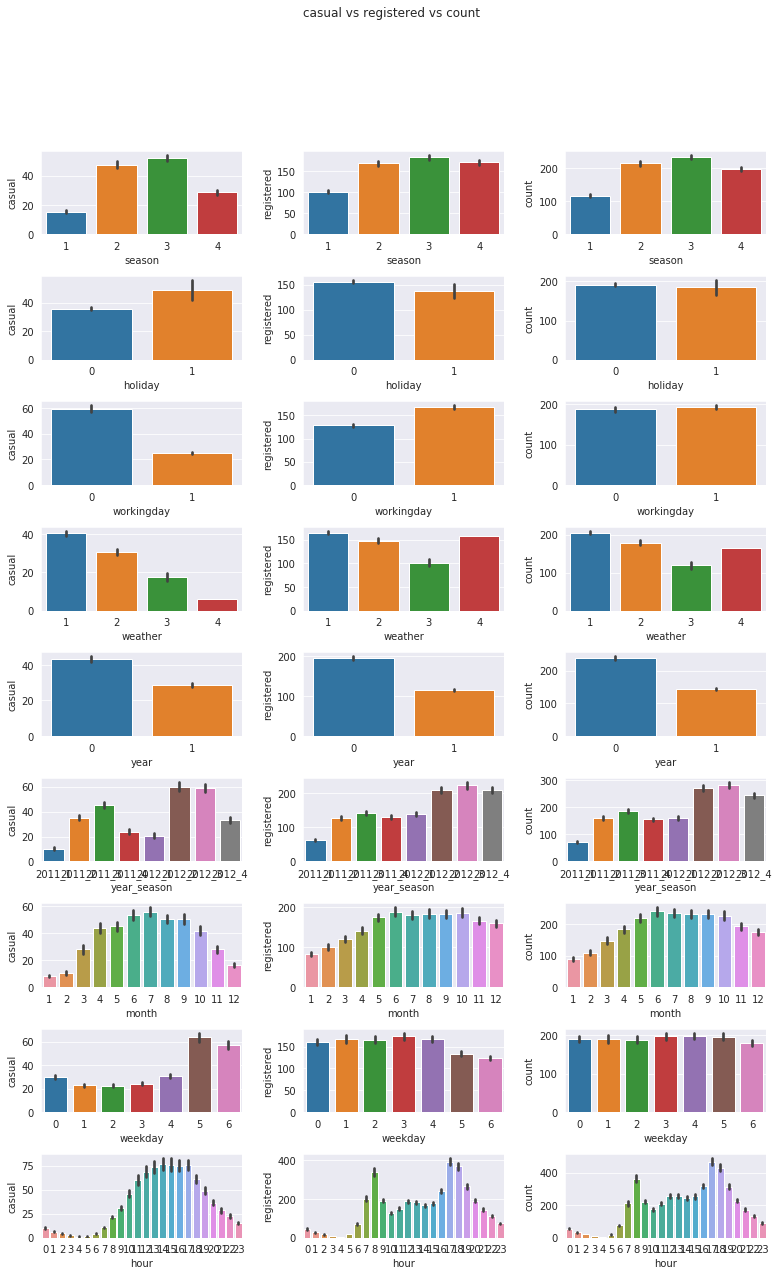

In [77]:
plt.figure(figsize=(13,20))
plt.suptitle('casual vs registered vs count')
plt.subplots_adjust(hspace = 0.5, wspace = 0.3)
col_list = ["season","holiday","workingday","weather","year","year_season","month","weekday","hour"]
count_list = ["casual","registered","count"]

for i, col in enumerate(col_list):
    for j, con in enumerate(count_list):
        plt.subplot(9,3,3*i+j+1)
        sns.barplot(train[col],train[con])

In count of holiday, workingday and weekday, there is no difference depending on categories.
but in registered and casual, it depend of the categories. So need to look at this part differently.

see relationship between weekday and each count by workingday and holiday

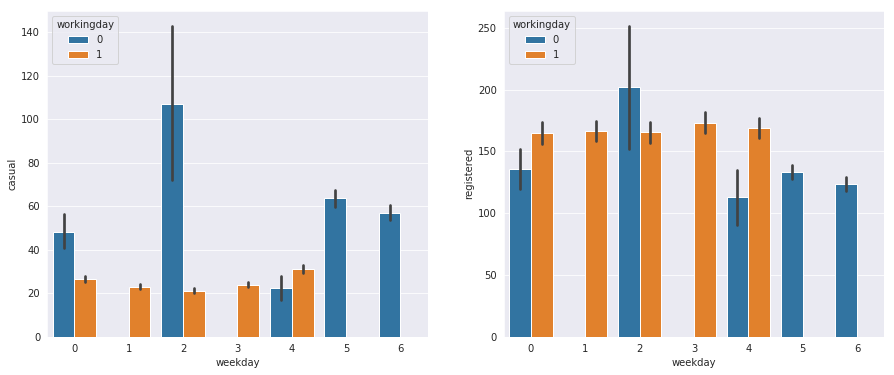

In [78]:
plt.figure(figsize=(15,6))
plt.subplot(121)
sns.barplot(x="weekday", y="casual", hue="workingday", data=train)
plt.subplot(122)
sns.barplot(x="weekday", y="registered", hue="workingday", data=train)

There is no holiday in Tuesday and Thursday.
And there is differences when Monday, Wednesday, and Friday.

In [79]:
train.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,hour,weekday,month,year,year_season
0,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0,5,1,1,2011_1
1,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1,5,1,1,2011_1
2,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2,5,1,1,2011_1
3,1,0,0,1,9.84,14.395,75,0.0,3,10,13,3,5,1,1,2011_1
4,1,0,0,1,9.84,14.395,75,0.0,0,1,1,4,5,1,1,2011_1


see relationship between hour and each count by workingday and holiday

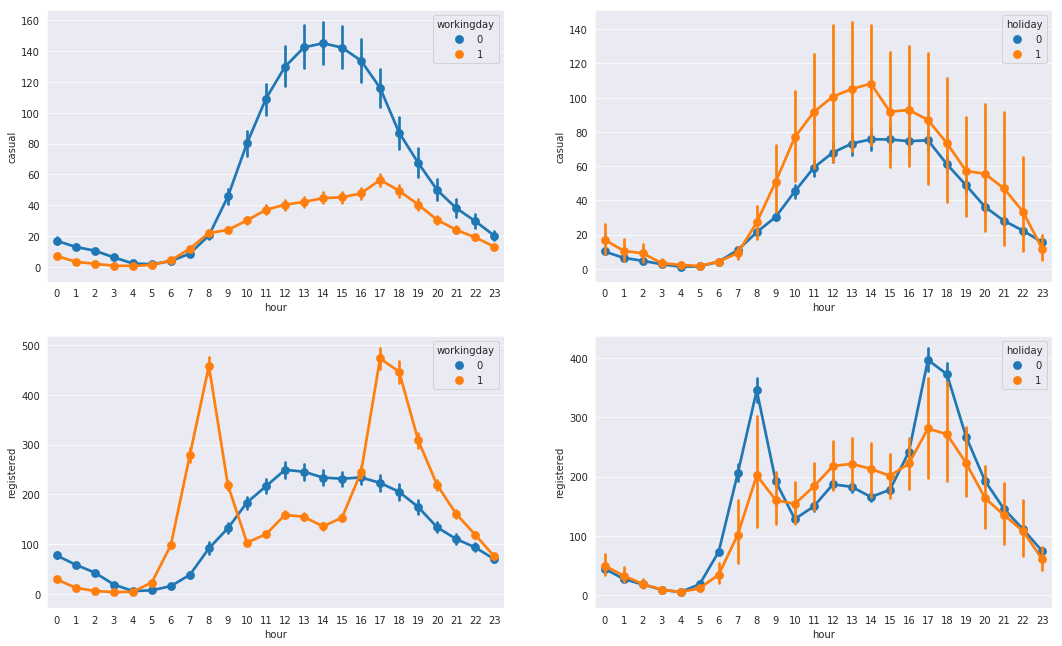

In [80]:
plt.figure(figsize=(18,11))
plt.subplot(221)
sns.pointplot(x="hour", y="casual", hue="workingday", data=train)
plt.subplot(222)
sns.pointplot(x="hour", y="casual", hue="holiday", data=train)
plt.subplot(223)
sns.pointplot(x="hour", y="registered", hue="workingday", data=train)
plt.subplot(224)
sns.pointplot(x="hour", y="registered", hue="holiday", data=train)
# train.pivot_table(index="hour", columns="workingday", aggfunc="size")

The number of registered and casual according to workingday and holiday show the opposite pattern.
And there are differences in the number of registered according to workingday at the closing hour and the office-going hour.
So many registered is can be expected to workers.

## correlation

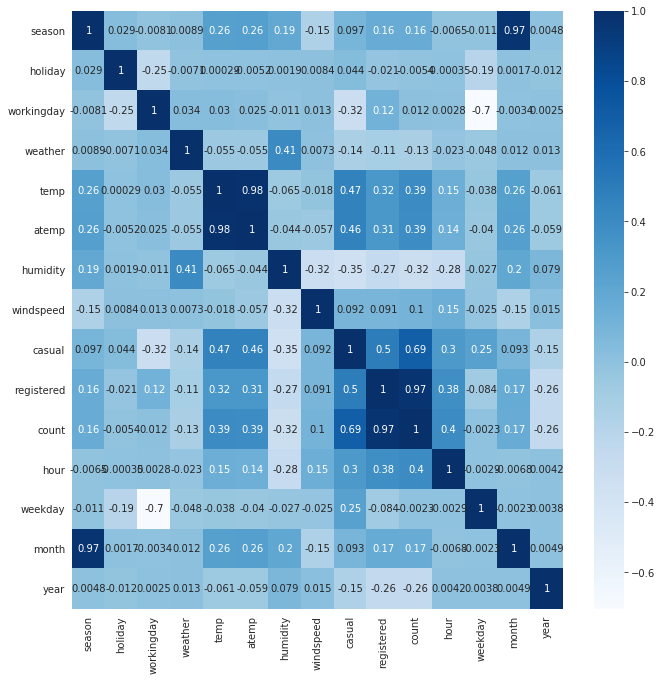

In [81]:
plt.figure(figsize=(11,11))
sns.heatmap(train.corr(),annot=True,cmap="Blues")

temp and atemp have high correlation and register and have too.
And windspeed and outcomes have low correlation(<=0.1)
See scatterplot of temp and atemp.

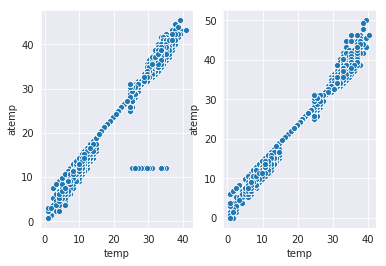

In [82]:
for i, df in enumerate([train,test]):
    plt.subplot(1,2,i+1)
    sns.scatterplot(x = 'temp', y = 'atemp',data = df)

In train data, there is strange pattern, but not in test.
It seems to be haved wrong value in atemp.
So based on correlation and scatterplot, judged to remove atemp

Based on the above results, make new variable.

In [83]:
df_list = {"train":None, "test" : None}
for name, df in zip(df_list.keys(),[train, test]):
    df['windspeed'] = np.log(df['windspeed']+1)
    df["weekday_working"] = df["weekday"]*df["workingday"]
    df["weekday_holiday"] = df["weekday"]*df["holiday"]
    df['casual_workhour'] = df[['hour', 'workingday']].apply(lambda x: int(x['workingday'] == 0 and 10 <= x['hour'] <= 19), axis=1)
    df['casual_holi_hour'] = df[['hour', 'holiday']].apply(lambda x: int(x['holiday'] == 1 and 9 <= x['hour'] <= 22), axis=1)
    df['register_workhour'] = df[['hour', 'workingday']].apply(
      lambda x:int((x['workingday'] == 1 and (6 <= x['hour'] <= 8 or 17 <= x['hour'] <= 20))
        or (x['workingday'] == 0 and 10 <= x['hour'] <= 15)), axis=1)
    df['register_holi_hour'] = df[['hour', 'holiday']].apply(
      lambda x:int(x['holiday'] == 0 and (7 <= x['hour'] <= 8 or 17 <= x['hour'] <= 18)), axis=1)
    df.drop('atemp',axis=1,inplace=True)
by_season = train.groupby('year_season')[['count']].median()
by_season.columns = ['count_season']
train1 = train.join(by_season, on='year_season').drop('year_season',axis=1)
test1 = test.join(by_season, on='year_season').drop('year_season',axis=1)

#### Divide predictors and outcomes. And take logging outcomes to normalize.

In [84]:
from sklearn.model_selection import train_test_split
y_list = ["casual","registered","count"]
train_x = train1[[col for col in train1.columns if col not in ['casual','registered', 'count']]]
train_y = np.log(train1[y_list]+1)

### Modeling

1. lightgbm + cross validation

Use lightgbm model, and use cross-validation to prevent overfitting

In [85]:
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

folds = KFold(n_splits = 5, shuffle = True, random_state = 123)
rms1,rms2 = [],[]
models1,models2 = [], []
for n_fold, (trn_idx, val_idx) in enumerate(folds.split(train1)) :
    x_train, y_train = train_x.ix[trn_idx], train_y.ix[trn_idx] 
    x_val, y_val = train_x.ix[val_idx], train_y.ix[val_idx]
    
    lgb_param = {'boosting_type':'gbdt',
             'num_leaves': 45,
             'max_depth': 30,
            'learning_rate': 0.01, 
            'bagging_fraction' : 0.9,
            'bagging_freq': 20,
            'colsample_bytree': 0.9,
             'metric': 'rmse',
            'min_child_weight': 1,
            'min_child_samples': 10,
             'zero_as_missing': True,
            'objective': 'regression',
            }
    train_set1 = lgb.Dataset(x_train, y_train["registered"], silent=False)
    valid_set1 = lgb.Dataset(x_val, y_val["registered"], silent=False)
    lgb_model1 = lgb.train(params = lgb_param, train_set = train_set1 , num_boost_round=5000, early_stopping_rounds=100,verbose_eval=500, valid_sets=valid_set1)
    train_set2 = lgb.Dataset(x_train, y_train["casual"], silent=False)
    valid_set2 = lgb.Dataset(x_val, y_val["casual"], silent=False)
    lgb_model2 = lgb.train(params = lgb_param, train_set = train_set2 , num_boost_round=5000, early_stopping_rounds=100,verbose_eval=500, valid_sets=valid_set2)
    models1.append(lgb_model1)
    models2.append(lgb_model2)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  if __name__ == '__main__':
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  # Remove the CWD from sys.path while we load stuff.


Training until validation scores don't improve for 100 rounds
[500]	valid_0's rmse: 0.284248
[1000]	valid_0's rmse: 0.269927
Early stopping, best iteration is:
[1319]	valid_0's rmse: 0.2677
Training until validation scores don't improve for 100 rounds
[500]	valid_0's rmse: 0.477807
[1000]	valid_0's rmse: 0.46767
[1500]	valid_0's rmse: 0.464973
Early stopping, best iteration is:
[1660]	valid_0's rmse: 0.464271
Training until validation scores don't improve for 100 rounds
[500]	valid_0's rmse: 0.295005
[1000]	valid_0's rmse: 0.277392
[1500]	valid_0's rmse: 0.272983
Early stopping, best iteration is:
[1683]	valid_0's rmse: 0.27227
Training until validation scores don't improve for 100 rounds
[500]	valid_0's rmse: 0.486602
[1000]	valid_0's rmse: 0.47548
[1500]	valid_0's rmse: 0.472322
Early stopping, best iteration is:
[1677]	valid_0's rmse: 0.47162
Training until validation scores don't improve for 100 rounds
[500]	valid_0's rmse: 0.307808
[1000]	valid_0's rmse: 0.289592
[1500]	valid_0's 

see feature importance

[Text(0, 0, 'hour'),
 Text(0, 0, 'humidity'),
 Text(0, 0, 'temp'),
 Text(0, 0, 'weekday'),
 Text(0, 0, 'windspeed'),
 Text(0, 0, 'month'),
 Text(0, 0, 'count_season'),
 Text(0, 0, 'weather'),
 Text(0, 0, 'weekday_working'),
 Text(0, 0, 'season'),
 Text(0, 0, 'workingday'),
 Text(0, 0, 'year'),
 Text(0, 0, 'register_workhour'),
 Text(0, 0, 'holiday'),
 Text(0, 0, 'register_holi_hour'),
 Text(0, 0, 'casual_workhour'),
 Text(0, 0, 'weekday_holiday'),
 Text(0, 0, 'casual_holi_hour')]

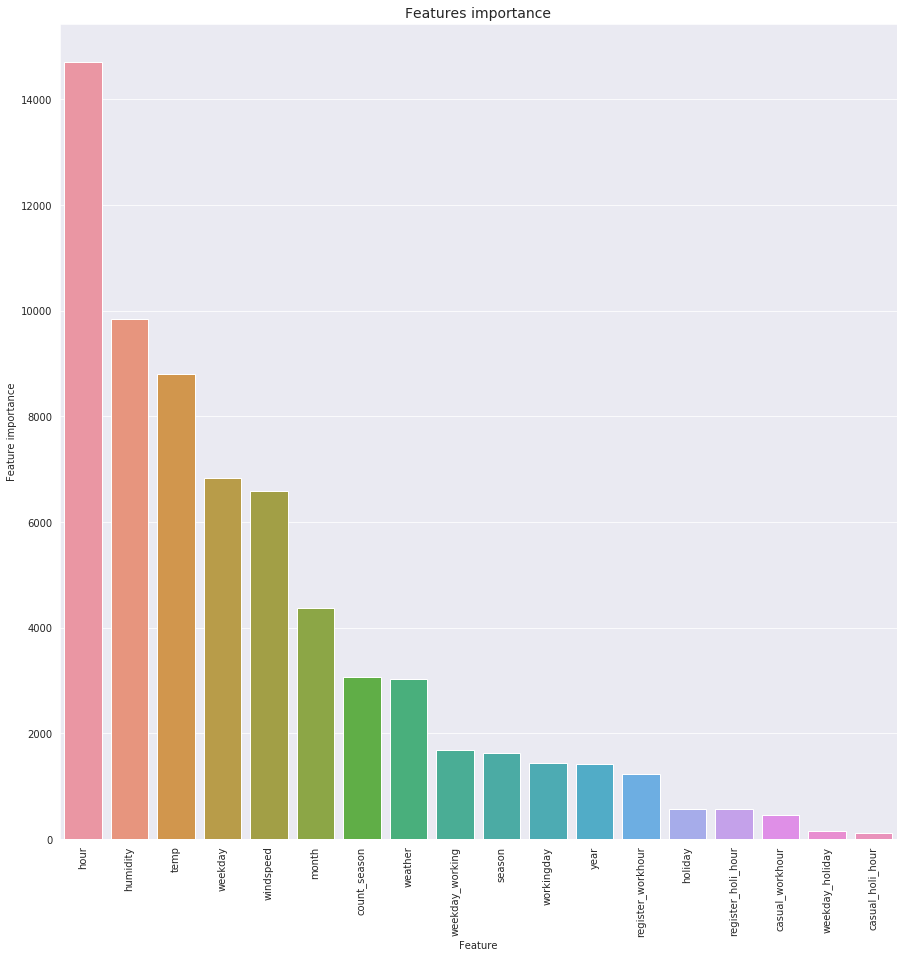

In [86]:
tmp = pd.DataFrame({'Feature': x_train.columns, 'Feature importance': lgb_model1.feature_importance()})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (15,15))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)

In [87]:
preds = []
for model in models1:
    regi_pred = model.predict(test1)
    preds.append(regi_pred)
fin_casual = np.mean(preds, axis=0)

preds = []
for model in models2:
    casual_pred = model.predict(test1)
    preds.append(casual_pred)
fin_regi = np.mean(preds, axis=0)
count_pred1 = np.exp(fin_casual) + np.exp(fin_regi) - 2

2. lgbmRegressor + crossvalidation + Bayesian optimization

In [88]:
from sklearn.model_selection import KFold 
from sklearn.metrics import mean_squared_error
def lgb_cv(num_leaves, learning_rate, n_estimators, reg_alpha, reg_lambda, min_split_gain, min_child_weight,min_child_samples, colsample_bytree, x_data=None, y_data=None, n_splits=5, output='score'):
    score = 0
    kf = KFold(n_splits=n_splits)
    models = []
    for train_index, valid_index in kf.split(x_data):
        x_train, y_train = x_data.iloc[train_index], y_data[train_index]
        x_valid, y_valid = x_data.iloc[valid_index], y_data[valid_index]
        
        model = lgb.LGBMRegressor(
            num_leaves = int(num_leaves), 
            learning_rate = learning_rate, 
            n_estimators = int(n_estimators), 
            reg_alpha = reg_alpha, 
            reg_lambda = reg_lambda,
            min_split_gain= min_split_gain,
            min_child_weight = min_child_weight,
            min_child_samples = int(min_child_samples),
            colsample_bytree = np.clip(colsample_bytree, 0, 1), 
        )
        
        model.fit(x_train, y_train)
        models.append(model)
        
        pred = model.predict(x_valid)
        true = y_valid
        score -= mean_squared_error(true, pred)/n_splits
    
    if output == 'score':
        return score
    if output == 'model':
        return models

In [89]:
from functools import partial 
from bayes_opt import BayesianOptimization
func_fixed1 = partial(lgb_cv, x_data=train_x, y_data=train_y["casual"], n_splits=5, output='score')
func_fixed2 = partial(lgb_cv, x_data=train_x, y_data=train_y["registered"], n_splits=5, output='score')
lgbBO = BayesianOptimization(
    func_fixed1, 
    {
        'num_leaves': (30, 100),    
        'learning_rate': (0.001, 0.015),  
        'n_estimators': (1000, 3000),                        
        'reg_alpha': (0.0001, 1),       
        'reg_lambda': (0.0001, 1), 
        'min_split_gain' : (0.001, 0.1),
        'min_child_weight' : (0.001, 0.1),
        'min_child_samples' : (10,25),
        'colsample_bytree': (0.85, 1.0),
    }, 
    random_state=4321            
)
lgbBO.maximize(init_points=5, n_iter=20)
lgbB1 = BayesianOptimization(
    func_fixed2, 
    {
        'num_leaves': (30, 100),    
        'learning_rate': (0.001, 0.015),  
        'n_estimators': (1000, 3000),                        
        'reg_alpha': (0.0001, 1),       
        'reg_lambda': (0.0001, 1), 
        'min_split_gain' : (0.001, 0.1),
        'min_child_weight' : (0.001, 0.1),
        'min_child_samples' : (10,25),
        'colsample_bytree': (0.85, 1.0),
    }, 
    random_state=4321            
)
lgbB1.maximize(init_points=5, n_iter=20)

|   iter    |  target   | colsam... | learni... | min_ch... | min_ch... | min_sp... | n_esti... | num_le... | reg_alpha | reg_la... |
-------------------------------------------------------------------------------------------------------------------------------------
|  1        | -0.3131   |  0.8606   |  0.01241  |  21.52    |  0.02935  |  0.02012  |  2.958e+0 |  58.44    |  0.7578   |  0.08924  |
|  2        | -0.3214   |  0.8965   |  0.009665 |  16.9     |  0.02261  |  0.06669  |  2.357e+0 |  96.52    |  0.2813   |  0.6199   |
|  3        | -0.3103   |  0.9075   |  0.006605 |  24.14    |  0.09306  |  0.09489  |  1.751e+0 |  53.96    |  0.6648   |  0.04242  |
|  4        | -0.3055   |  0.8848   |  0.007021 |  11.17    |  0.07689  |  0.08554  |  1.301e+0 |  37.08    |  0.271    |  0.03026  |
|  5        | -0.3145   |  0.9757   |  0.009366 |  23.97    |  0.05006  |  0.03827  |  1.488e+0 |  72.13    |  0.3298   |  0.4617   |
|  6        | -0.3062   |  0.9796   |  0.01284  |  19.81    | 

|  10       | -0.1736   |  0.9535   |  0.008241 |  12.59    |  0.03038  |  0.03574  |  1.322e+0 |  50.52    |  0.8605   |  0.5234   |
|  11       | -0.177    |  0.8685   |  0.01053  |  24.37    |  0.008789 |  0.08315  |  2.705e+0 |  99.86    |  0.8311   |  0.9279   |
|  12       | -0.1754   |  0.9643   |  0.01306  |  24.95    |  0.08368  |  0.0373   |  1.934e+0 |  99.59    |  0.3135   |  0.5114   |
|  13       | -0.1765   |  0.9514   |  0.007214 |  11.75    |  0.02411  |  0.04252  |  1.665e+0 |  97.44    |  0.6518   |  0.5645   |
|  14       | -0.1744   |  0.9222   |  0.01023  |  24.1     |  0.01669  |  0.01277  |  1.194e+0 |  95.69    |  0.2553   |  0.07588  |
|  15       | -0.1765   |  0.8688   |  0.002452 |  24.91    |  0.03794  |  0.005666 |  2.998e+0 |  99.98    |  0.6157   |  0.7725   |
|  16       | -0.1966   |  0.8981   |  0.001401 |  18.31    |  0.04719  |  0.02375  |  2.998e+0 |  32.68    |  0.8943   |  0.6744   |
|  17       | -0.1769   |  0.9455   |  0.002321 |  24.7     | 

In [90]:
params1 = lgbBO.max['params']
params2 = lgbB1.max['params']
lgb_models1 = lgb_cv(
    params1['num_leaves'], 
    params1['learning_rate'], 
    params1['n_estimators'], 
    params1['reg_alpha'], 
    params1['reg_lambda'], 
    params1['min_split_gain'], 
    params1['min_child_weight'],
    params1['min_child_samples'],
    params1['colsample_bytree'],
    x_data=train_x, y_data=train_y["casual"], n_splits=5, output='model')
lgb_models2 = lgb_cv(
    params2['num_leaves'], 
    params2['learning_rate'], 
    params2['n_estimators'], 
    params2['reg_alpha'], 
    params2['reg_lambda'], 
    params2['min_split_gain'], 
    params2['min_child_weight'],
    params2['min_child_samples'],
    params2['colsample_bytree'],
    x_data=train_x, y_data=train_y["registered"], n_splits=5, output='model')
preds = []
for model in lgb_models1:
    pred = model.predict(test1)
    preds.append(pred)
casual_pred = np.mean(preds, axis=0)
preds = []
for model in lgb_models2:
    pred = model.predict(test1)
    preds.append(pred)
registered_pred = np.mean(preds, axis=0)
count_pred2 = np.exp(casual_pred) + np.exp(registered_pred) - 2

3. randomforest and gradientboostingregressor

In [91]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
preds = {}
regs = {"gbdt": GradientBoostingRegressor(random_state=0),
        "rf": RandomForestRegressor(random_state=0, n_jobs=-1)}
for name, reg in regs.items():
    if name == 'gbdt':
        reg.set_params(n_estimators=1500, min_samples_leaf=6)
    elif name == 'rf':
        reg.set_params(n_estimators=1500, min_samples_leaf=2)
    reg.fit(train_x, train_y['casual'])
    pred_casual = reg.predict(test1)
    pred_casual = np.exp(pred_casual) - 1
    pred_casual[pred_casual < 0] = 0
    if name == 'gbdt':
        reg.set_params(n_estimators=1500, min_samples_leaf=6)
    elif name == 'rf':
        reg.set_params(n_estimators=1500, min_samples_leaf=2)
    reg.fit(train_x, train_y['registered'])
    pred_registered = reg.predict(test1)
    pred_registered = np.exp(pred_registered) - 1
    pred_registered[pred_registered < 0] = 0
    preds[name] = pred_casual + pred_registered

[Text(0, 0, 'hour'),
 Text(0, 0, 'count_season'),
 Text(0, 0, 'register_workhour'),
 Text(0, 0, 'weekday'),
 Text(0, 0, 'workingday'),
 Text(0, 0, 'temp'),
 Text(0, 0, 'humidity'),
 Text(0, 0, 'month'),
 Text(0, 0, 'weather'),
 Text(0, 0, 'register_holi_hour'),
 Text(0, 0, 'windspeed'),
 Text(0, 0, 'weekday_working'),
 Text(0, 0, 'year'),
 Text(0, 0, 'casual_workhour'),
 Text(0, 0, 'season'),
 Text(0, 0, 'holiday'),
 Text(0, 0, 'weekday_holiday'),
 Text(0, 0, 'casual_holi_hour')]

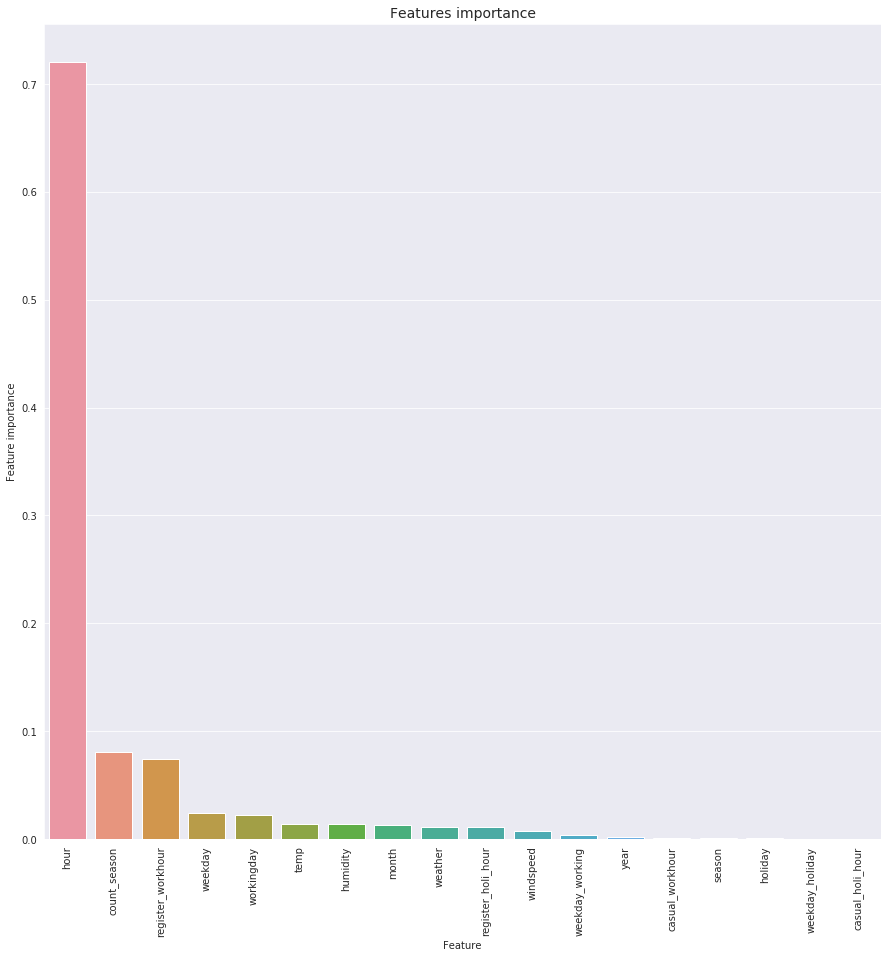

In [92]:
tmp = pd.DataFrame({'Feature': x_train.columns, 'Feature importance': reg.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (15,15))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)

In [93]:
pred_mean = (count_pred1 + count_pred2 + preds['gbdt'] + preds['rf'])/4
sample = pd.read_csv("../input/bike-sharing-demand/sampleSubmission.csv")
sample["count"] = pred_mean
sample.to_csv("sample.csv",index=False)

Result rmsle is 0.38081